In [3]:
import numpy as np 
import matplotlib.pyplot as plt 
from IPython.display import clear_output #
import pandas as pd 

In [4]:
y = np.array([21,20,15])
n = np.array([48,34,21])
Z = np.array([10,30,50])

data_air = np.zeros((3,3))
data_air[:,0] = y
data_air[:,1] = n
data_air[:,2] = Z

print("------------------ Données Air -----------------------")
print(pd.DataFrame(data_air, columns= ["y", "n", "z"]))
print("--------------------------------------------------")

------------------ Données Air -----------------------
      y     n     z
0  21.0  48.0  10.0
1  20.0  34.0  30.0
2  15.0  21.0  50.0
--------------------------------------------------


In [52]:
def Gibbs_sampler(nchain, data, init_theta, init_x, sd_theta, sd_x, sigma1, sigma2, tau):
    #tableau pour theta 
    theta_chain = np.zeros((nchain+1, 2)) #theta1, theta2
    theta_chain[0] = init_theta
    #tableau pour X
    x_chain = np.zeros((nchain+1,3)) #X1, X2, X3
    x_chain[0] = init_x
    #obs
    y = data[:, 0]
    n = data[:, 1]
    z = data[:, 2]
    alpha = 4.48
    beta = .76
    #paramètre de la moyenne des xi
    mu = alpha + beta * z 
    
    for i in range(nchain):
        ################ MAJ theta 1 #####################
        new_candidate = theta_chain[i, 0] + np.random.normal(scale = sd_theta[0])
        new_eta = new_candidate + theta_chain[i, 1] * x_chain #vecteur de 3
        eta = theta_chain[i, 0] + theta_chain[i, 1] * x_chain
        top = -(new_candidate**2/2*sigma1) - (y* np.log(1+np.exp(-new_eta))).sum() + ((y-n) * np.log(1+np.exp(new_eta))).sum()
        bottom = -(theta_chain[i, 0]**2/2*sigma1) - (y* np.log(1+np.exp(-eta))).sum() + ((y-n) * np.log(1+np.exp(eta))).sum()
        ratio = top - bottom
        u = np.log(np.random.uniform())
        if u < ratio:
            theta_chain[i+1, 0] = new_candidate
        else :
            theta_chain[i+1, 0] = theta_chain[i, 0]
        
        #################### MAJ theta 2 ############## 
        new_candidate = theta_chain[i, 1] + np.random.normal(scale = sd_theta[1])
        ####
        new_eta = theta_chain[i+1, 0] + new_candidate * x_chain[i,:] #on part de la dernière MAJ de theta1
        eta = theta_chain[i+1, 0] + theta_chain[i, 1] * x_chain[i, :] #on passe à +1 pour le theta2 car MAJ coord par coord 
        ######
        top = -(new_candidate**2/2*sigma2) - (y* np.log(1+np.exp(-new_eta))).sum() + ((y-n) * np.log(1+np.exp(new_eta))).sum()
        bottom = -(theta_chain[i, 1]**2/2*sigma2) - (y* np.log(1+np.exp(-eta))).sum() + ((y-n) * np.log(1+np.exp(eta))).sum()
        ratio = top - bottom
        u = np.log(np.random.uniform())
        if u < ratio:
            theta_chain[i+1, 1] = new_candidate
        else :
            theta_chain[i+1, 1] = theta_chain[i, 1]
        
        ############### MAJ des Xj ####################@
        #on definit les muj à partir de derniere MAJ des theta 
        eta = theta_chain[i+1, 0] + theta_chain[i+1, 1] * x_chain[i,:] 
        for j in range(3):
            new_candidate = x_chain[i, j] + np.random.normal(scale = sd_x )
            top = -((new_candidate - mu[j])**2 / 2*tau) - y[j] * np.log(1+np.exp(-eta[j])) + (y[j]-n[j]) * np.log(1+np.exp(eta[j]))
            bottom = -((x_chain[i, j] - mu[j])**2 / 2*tau) - y[j] * np.log(1+np.exp(-eta[j])) + (y[j]-n[j]) * np.log(1+np.exp(eta[j]))
            ratio = top-bottom
            u = np.log(np.random.uniform())
            if u < ratio:
                x_chain[i+1, j] = new_candidate
            else :
                x_chain[i+1, j] = x_chain[i, j]
        if i % 100 == 0:
            clear_output(wait = True)
            print(f"Iteration : {i}")
        
    return theta_chain, x_chain
      
        
    

In [59]:
#hyperparm 
tau2 = 81.14 #variance pour les Xj (dans le papier)
sigma1 = 100 #variance pour theta1
sigma2 = 100 #variance pour theta2
prop_sdx = .5 #pas du noyau de proposition pour les Xi
sd_theta1 = .09 #pas du noyau de proposition pour theta1
sd_theta2 = .1 #pas du noyau de proposition pour theta2

theta, X = Gibbs_sampler(21000, data_air, np.array([0, 0]), np.zeros(3), np.array([sd_theta1, sd_theta2]), prop_sdx, sigma1, sigma2, tau2)

Iteration : 20900


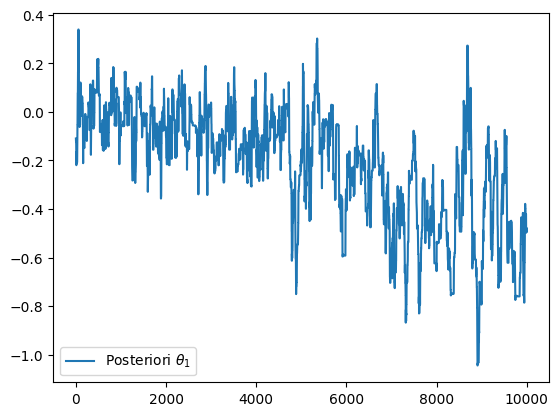

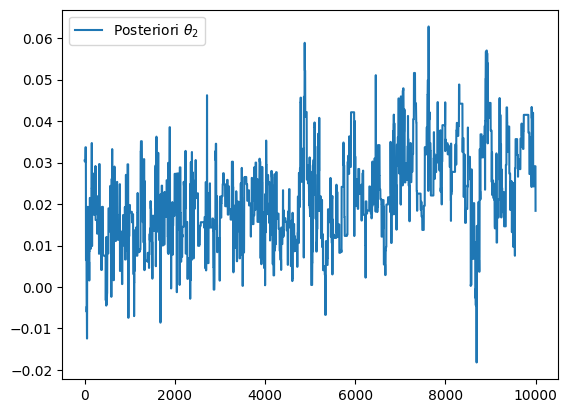

In [60]:
plt.plot(theta[11000:, 0], label = r'Posteriori $\theta_1$')
plt.legend()
plt.show()
plt.plot(theta[11000:, 1], label = r'Posteriori $\theta_2$')
plt.legend()

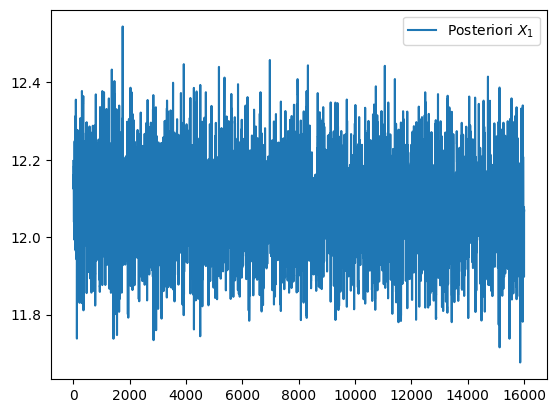

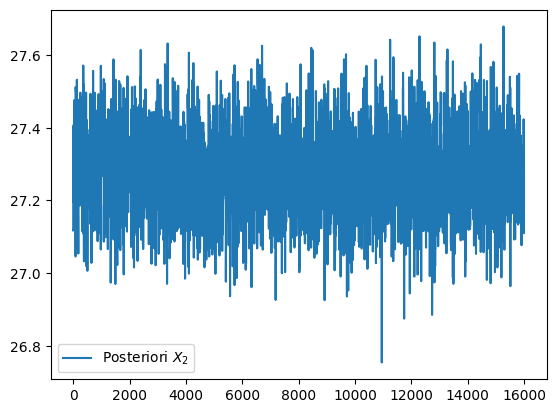

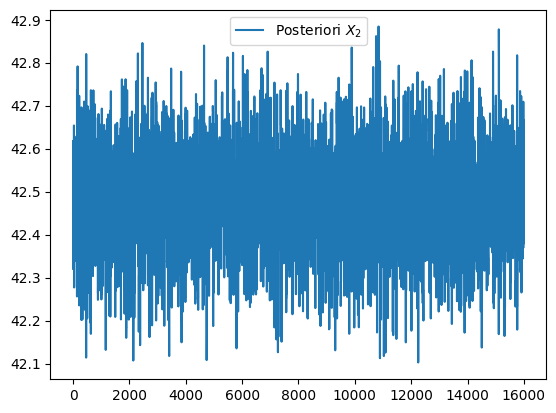

In [61]:
plt.plot(X[5000:, 0], label = r'Posteriori $X_1$')
plt.legend()
plt.show()
plt.plot(X[5000:, 1], label = r'Posteriori $X_2$')
plt.legend()
plt.show()
plt.plot(X[5000:, 2], label = r'Posteriori $X_3$')
plt.legend()
plt.show()

In [62]:
#Tableau résumé : statistiques des différents paramètres ?
print("-------------------------------------------------------------------------------")
print(f"Estimateur en moyenne de Theta1 {round(np.mean(theta[11000: , 0]), 2)} et variance de la loi a posteriori {round(np.std(theta[11000: , 0]), 2)}")
print(f"Estimateur en moyenne de Theta2 {round(np.mean(theta[11000: , 1]),2)} et variance de la loi a posteriori {round(np.std(theta[11000: , 1]),2)}")
print(f"Estimateur en moyenne de X1 {round(np.mean(X[11000: , 0]),2)} et variance de la loi a posteriori {round(np.std(X[11000: , 0]),2)}")
print(f"Estimateur en moyenne de X2 {round(np.mean(X[11000: , 1]),2)} et variance de la loi a posteriori {round(np.std(X[11000: , 1]),2)}")
print(f"Estimateur en moyenne de X3 {round(np.mean(X[11000: , 2]),2)} et variance de la loi a posteriori {round(np.std(X[11000: , 2]),2)}")

-------------------------------------------------------------------------------
Estimateur en moyenne de Theta1 -0.22 et variance de la loi a posteriori 0.24
Estimateur en moyenne de Theta2 0.02 et variance de la loi a posteriori 0.01
Estimateur en moyenne de X1 12.08 et variance de la loi a posteriori 0.11
Estimateur en moyenne de X2 27.27 et variance de la loi a posteriori 0.11
Estimateur en moyenne de X3 42.48 et variance de la loi a posteriori 0.11
